In [43]:
import numpy as np
from math import sqrt, log, inf, pi, atan, exp
from random import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [29]:
def get_lin_reg(x, y):
    cnt_points = len(x)

    sumsq_x, sc_xy, sum_x, sum_y = 0, 0, 0, 0
    for i in range(cnt_points):
        sumsq_x += x[i] ** 2
        sc_xy += x[i] * y[i]
        sum_x += x[i]
        sum_y += y[i]

    det = sumsq_x * cnt_points - sum_x ** 2
    H = (sc_xy * cnt_points - sum_x * sum_y) / det
    c = (sumsq_x * sum_y - sum_x * sc_xy) / det

    return H, c

In [103]:
def analysisRS(data, min_size=20, max_size=None):

    len_data = len(data)
    RS = []
    if max_size is None:
        max_size = max(len_data // 2, min_size + 1)
    periods = list(range(min_size, max_size))

    for n in periods:
        val_RS = 0
        m = len_data // n

        for i in range(m):
            sum_val_sq = 0
            sml_sum = [0]
            for j in range(i * n, (i + 1) * n):
                sum_val_sq += data[j] ** 2
                sml_sum += [sml_sum[-1] + data[j]]

            S = sqrt(sum_val_sq / n - (sml_sum[-1] / n) ** 2)

            min_val, max_val = +inf, -inf
            for j in range(1, n + 1):

                val = sml_sum[j] - j * sml_sum[-1] / n
                if val < min_val:
                    min_val = val
                if val > max_val:
                    max_val = val

            val_RS += (max_val - min_val) / S

        RS += [log(val_RS / m)]

    return list(map(log, periods)), RS

In [102]:
def get_Hc_vectors(data, num_batch=None):
    len_data = len(data)
    if num_batch is None:
        num_batch = len_data // 5000
    len_batch = len_data // num_batch

    vec_H, vec_c = [None] * num_batch, [None] * num_batch

    with tqdm(total=num_batch, position=0, leave=True) as pbar:
        for i in range(num_batch):

            pbar.set_description(f"Batch: {i+1}/{num_batch}")
            pbar.update()

            per, RS = analysisRS(data[len_batch*i:len_batch*(i+1)])
            vec_H[i], vec_c[i] = get_lin_reg(per, RS)

    return vec_H, vec_c

In [94]:
def print_H_alalysis(data, vec_H, num_batch):
    len_data = len(data)
    min_data, max_data = min(data), max(data)
    len_batch = len_data // num_batch

    plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
    plt.plot(data)
    plt.ylim(min_data - 0.1, max_data + 0.1)
    plt.xticks([len_batch // 2 + len_batch * i for i in range(num_batch)],
               [str(round(i, 2)) for i in vec_H])

    for i in range(num_batch + 1):
        plt.vlines(len_batch * i, min_data - 1, max_data + 1, 'y')

In [74]:
def pink_noise(length, time_rel=[1, 10, 100]):
    p = list(map(lambda x: exp(-1/x), time_rel))

    num_per = len(p)
    rel_x, vals = [0] * num_per, [0] * length
    sums = 0

    for i in range(length + 100):
        for j in range(num_per):
            rel_x[j] = p[j] * rel_x[j] + sqrt(1 - p[j] ** 2) * random()
            if i >= 100:
                vals[i - 100] += rel_x[j]

        if i >= 100:
            sums += vals[i - 100]

    sums /= length
    for i in range(length):
        vals[i] -= sums

    return vals

In [35]:
cnt_points = 50000
meshgrid = [(i + 1) / cnt_points * 20 * pi for i in range(cnt_points + 1)]

x = [atan(i) + np.random.normal(0, 0.01, 1)[0] for i in meshgrid]

In [31]:
per, RS = analysisRS(x[:1000])
H2, c2 = get_lin_reg(per, RS)

vec_res_line2 = [H2 * i + c2 for i in per]
print(H2)
print(c2)

1.3167683609424201
-2.8259837542902018


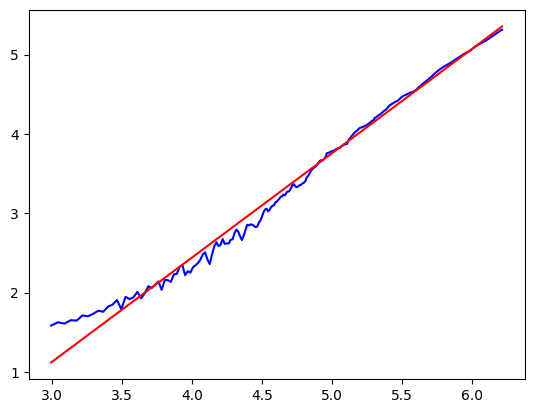

In [32]:
plt.plot(per, RS, "b")
plt.plot(per, vec_res_line2, "r")

In [101]:
vall = pink_noise(100000)
B0 = [0]
for i in vall:
    B0 += [B0[-1] + i]

In [104]:
vec_H, vec_c = get_Hc_vectors(vall, 30)

Batch: 30/30: 100%|████████████████████████████████████████████████████████████████████| 30/30 [02:29<00:00,  4.98s/it]


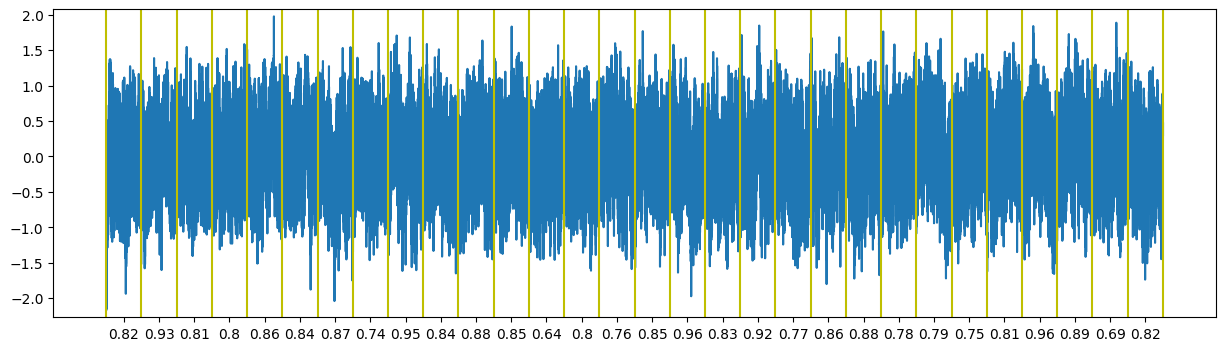

In [105]:
print_H_alalysis(vall, vec_H, 30)

In [106]:
print(sum(vec_H) / len(vec_H))

0.8314325553555434
